# 11 — 3-Level Comparison: Baseline vs CRF vs Multi-Task

Dekomposisi kontribusi setiap komponen arsitektur:

| Level | Model | Deskripsi |
|-------|-------|----------|
| 1 | IndoBERT + Softmax | Baseline paling basic (token classification) |
| 2 | IndoBERT + CRF | Menambah structural constraint (valid sequence) |
| 3 | Hierarchical MTL + CRF | Multi-task learning (Wang et al., 2021) |

Setiap level dijalankan pada **2 dataset** (Original + Augmented) → **6 total runs**.

- Level 2 & 3 sudah ditraining di NB10 → load dari checkpoint
- Level 1 (Baseline Softmax) → **train baru di notebook ini**

**Hyperparameters** (sama dengan NB10):
- 50 epoch, patience=10, Dropout=0.1, WD=0.01
- LR BERT=2e-5, LR Head=1e-4, Batch=4, GradAccum=4

**Referensi:**

| Model | F1 |
|---|---|
| Penelitian sebelumnya (EMC-GCN) | 0.6761 |
| NB10: MT + Original | 0.7578 |
| NB10: MT + Augmented | 0.7442 |
| NB10: ST + Original | 0.7558 |
| NB10: ST + Augmented | 0.7600 |

In [1]:
import json
import os
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from seqeval.metrics import (
    classification_report,
    f1_score as seq_f1_score,
    precision_score as seq_precision_score,
    recall_score as seq_recall_score,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
AUG_TRAIN_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented_train.json')
AUG_VAL_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json')
NB10_CHECKPOINT = os.path.join(MODEL_DIR, 'checkpoint_extended_training.pt')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training config (same as NB10)
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
NUM_EPOCHS = 50
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
DROPOUT = 0.1
IGNORE_INDEX = -100
PATIENCE = 10
SEED = 42

PRIOR_RESEARCH_F1 = 0.6761

# Only baseline runs (Level 2 & 3 loaded from NB10)
RUNS = [
    {'name': 'Baseline + Original',  'model_type': 'baseline', 'data_type': 'original'},
    {'name': 'Baseline + Augmented', 'model_type': 'baseline', 'data_type': 'augmented'},
]

print(f'New runs: {len(RUNS)} (baseline softmax)')
print(f'NB10 checkpoint: {os.path.exists(NB10_CHECKPOINT)}')
print(f'Epochs: {NUM_EPOCHS}, Patience: {PATIENCE}')

New runs: 2 (baseline softmax)
NB10 checkpoint: True
Epochs: 50, Patience: 10


### 2. LOAD DATA & TOKENIZER

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

with open(AUG_TRAIN_PATH, 'r', encoding='utf-8') as f:
    raw_aug_train = json.load(f)
with open(AUG_VAL_PATH, 'r', encoding='utf-8') as f:
    raw_aug_val = json.load(f)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'Original data: {len(raw_data)}')
print(f'Augmented train: {len(raw_aug_train)}')
print(f'Augmented val: {len(raw_aug_val)}')

Original data: 2451
Augmented train: 4290
Augmented val: 368


### 3. LABELS & DATA PREPARATION

In [4]:
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}


def _tokenize_st_samples(raw_data, tokenizer):
    """Tokenize and align labels for baseline/single-task model."""
    all_input_ids, all_attention_mask, all_bieos, all_crf = [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        bieos_a, crf_a = [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            elif wid != prev_wid:
                if wid < len(tokens):
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                else:
                    bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            else:
                bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
    }


print('Preparing original data...')
st_orig_data = _tokenize_st_samples(raw_data, tokenizer)

print('Preparing augmented data...')
st_aug_train_data = _tokenize_st_samples(raw_aug_train, tokenizer)
st_aug_val_data = _tokenize_st_samples(raw_aug_val, tokenizer)

print(f'Original: {st_orig_data["input_ids"].shape[0]} samples')
print(f'Augmented train: {st_aug_train_data["input_ids"].shape[0]} | val: {st_aug_val_data["input_ids"].shape[0]}')

Preparing original data...
Preparing augmented data...
Original: 2451 samples
Augmented train: 4290 | val: 368


### 4. DATASET & MODEL CLASSES

In [5]:
class ABSADataset(Dataset):
    """Dataset with index-based splitting (for original data)."""
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


class FullDataset(Dataset):
    """Dataset for pre-split data (no index splitting needed)."""
    def __init__(self, data_dict):
        self.data = data_dict
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


class BaselineSoftmaxABSA(nn.Module):
    """Level 1: IndoBERT + Linear + Softmax — no CRF."""
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.classifier = nn.Linear(proj_dim, num_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, bieos_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        logits = self.classifier(self.proj(h))
        outputs = {'emissions': logits}
        if bieos_labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            outputs['loss'] = loss_fn(logits.view(-1, logits.size(-1)), bieos_labels.view(-1))
        return outputs

    def decode(self, emissions, attention_mask):
        """Argmax decoding — returns list of lists matching CRF decode format."""
        preds = emissions.argmax(dim=-1)
        mask = attention_mask.bool()
        return [preds[i][:mask[i].sum().item()].tolist() for i in range(preds.size(0))]


print('Model classes defined.')

Model classes defined.


### 5. TRAINING & EVALUATION FUNCTIONS

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds, zero_division=0)
    precision = seq_precision_score(all_true, all_preds, zero_division=0)
    recall = seq_recall_score(all_true, all_preds, zero_division=0)
    return avg_loss, f1, precision, recall, all_true, all_preds


def fmt_time(seconds):
    if seconds < 60:
        return f'{seconds:.0f}s'
    elif seconds < 3600:
        return f'{seconds/60:.1f}m'
    else:
        h = int(seconds // 3600)
        m = int((seconds % 3600) // 60)
        return f'{h}h{m:02d}m'


def train_model(model, train_loader, val_loader, device, num_epochs, patience,
                phase1_epochs=0, desc_prefix='', run_idx=0, total_runs=2,
                global_start_time=None):
    """Generic training loop."""
    bert_params = list(model.bert.named_parameters())
    head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]
    total_epochs = phase1_epochs + num_epochs
    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': [p for _, p in bert_params], 'lr': LR_BERT},
        {'params': [p for _, p in head_params], 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    has_subtasks = hasattr(model, 'apply_sentiment_connection')
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    if has_subtasks:
        history.update({'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []})
    epoch_times = []

    def elapsed_total_str():
        if global_start_time is not None:
            return f' | Elapsed: {fmt_time(time.time() - global_start_time)}'
        return ''

    def run_epoch(epoch_num, epoch_label):
        model.train()
        epoch_loss = 0
        epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0} if has_subtasks else None
        optimizer.zero_grad()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f'  {desc_prefix} {epoch_label}', leave=False)
        for step, batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs['loss'] / GRADIENT_ACCUMULATION
            loss.backward()
            if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            epoch_loss += outputs['loss'].item()
            if epoch_comp is not None and 'losses' in outputs:
                for k in epoch_comp:
                    epoch_comp[k] += outputs['losses'][k].item()
            pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}'})
        pbar.close()
        n = len(train_loader)
        avg_comp = {k: v / n for k, v in epoch_comp.items()} if epoch_comp else None
        return epoch_loss / n, avg_comp

    def subtask_str(comp):
        if comp is not None:
            return (f'\n      ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
                    f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')
        return ''

    # Phase 1 (multi-task only — not used for baseline)
    if phase1_epochs > 0 and has_subtasks:
        for ep in range(phase1_epochs):
            ep_t0 = time.time()
            train_loss, comp = run_epoch(ep + 1, f'P1 {ep+1}/{phase1_epochs}')
            val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_precision'].append(val_p)
            history['val_recall'].append(val_r)
            if comp:
                for k in comp:
                    history[f'loss_{k}'].append(comp[k])
            ep_elapsed = time.time() - ep_t0
            epoch_times.append(ep_elapsed)
            done_ep = len(epoch_times)
            avg_ep = sum(epoch_times) / done_ep
            remaining_ep = total_epochs - done_ep
            eta_run = avg_ep * remaining_ep
            remaining_runs = total_runs - run_idx - 1
            eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)
            print(f'    P1 {ep+1}/{phase1_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | '
                  f'F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} | {fmt_time(ep_elapsed)}/ep | '
                  f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
                  f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)
        model.apply_sentiment_connection()
        print(f'    Sentiment Connection applied', flush=True)

    # Main training
    for ep in range(num_epochs):
        global_ep = phase1_epochs + ep + 1
        ep_t0 = time.time()
        train_loss, comp = run_epoch(global_ep, f'Ep {global_ep}/{total_epochs}')
        val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_p)
        history['val_recall'].append(val_r)
        if comp:
            for k in comp:
                history[f'loss_{k}'].append(comp[k])
        ep_elapsed = time.time() - ep_t0
        epoch_times.append(ep_elapsed)

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_ep
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        done_ep = len(epoch_times)
        avg_ep = sum(epoch_times) / done_ep
        remaining_ep = total_epochs - done_ep
        if patience_counter > 0:
            remaining_ep = min(remaining_ep, patience - patience_counter)
        eta_run = avg_ep * max(remaining_ep, 0)
        remaining_runs = total_runs - run_idx - 1
        eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

        print(f'    Ep {global_ep:2d}/{total_epochs} | Train: {train_loss:.4f} | '
              f'Val: {val_loss:.4f} | F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} '
              f'{"*" if improved else " "} | {fmt_time(ep_elapsed)}/ep | '
              f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
              f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)

        if patience_counter >= patience:
            print(f'    Early stopped at epoch {global_ep}', flush=True)
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    _, final_f1, final_p, final_r, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds, zero_division=0)

    return {
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['val_f1']),
        'history': history,
        'report': report,
        'val_true': all_true,
        'val_preds': all_preds,
    }


print('Training functions defined.')

Training functions defined.


### 6. TRAIN BASELINE MODELS

2 runs: IndoBERT + Softmax pada data Original dan Augmented.

In [7]:
baseline_results = {}
run_counter = 0
total_runs = len(RUNS)
global_start = time.time()
run_times = []

# Pre-compute split indices for original data (seed=42, same as NB10)
total_orig = len(raw_data)
orig_indices = torch.randperm(total_orig, generator=torch.Generator().manual_seed(SEED))
orig_split = int(total_orig * TRAIN_RATIO)

print(f'Original split: train={orig_split}, val={total_orig - orig_split}')
print(f'Starting {total_runs} baseline runs')
print(f'Time: {datetime.now().strftime("%H:%M:%S")}\n')

for run_cfg in RUNS:
    run_name = run_cfg['name']
    data_type = run_cfg['data_type']

    elapsed_so_far = time.time() - global_start
    print(f'\n{"#"*60}')
    print(f'RUN {run_counter+1}/{total_runs}: {run_name}')
    print(f'{datetime.now().strftime("%H:%M:%S")} | Elapsed: {fmt_time(elapsed_so_far)}')
    print(f'{"#"*60}')

    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Prepare DataLoaders
    if data_type == 'original':
        train_ds = ABSADataset(st_orig_data, orig_indices[:orig_split])
        val_ds = ABSADataset(st_orig_data, orig_indices[orig_split:])
    else:
        train_ds = FullDataset(st_aug_train_data)
        val_ds = FullDataset(st_aug_val_data)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2)

    print(f'  Train: {len(train_ds)} | Val: {len(val_ds)} | Batches: {len(train_loader)}')

    model = BaselineSoftmaxABSA(
        model_name=MODEL_NAME, num_labels=len(bieos_labels),
        proj_dim=PROJ_DIM, dropout=DROPOUT,
    ).to(device)

    t0 = time.time()
    result = train_model(
        model, train_loader, val_loader, device,
        num_epochs=NUM_EPOCHS, patience=PATIENCE,
        phase1_epochs=0,
        desc_prefix=run_name[:6],
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start,
    )
    result['run_name'] = run_name
    result['model_type'] = 'baseline'
    result['data_type'] = data_type
    result['train_size'] = len(train_ds)
    result['elapsed_min'] = (time.time() - t0) / 60
    baseline_results[run_name] = result
    run_times.append(time.time() - t0)
    run_counter += 1

    avg_run = sum(run_times) / len(run_times)
    remaining = total_runs - run_counter
    print(f'  >> {run_name}: F1={result["best_f1"]:.4f} (ep {result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining} runs ~{fmt_time(avg_run * remaining)}')

    del model, train_loader, val_loader, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()

total_elapsed = time.time() - global_start
print(f'\n{"="*60}')
print(f'BASELINE RUNS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
print(f'Total time: {fmt_time(total_elapsed)}')
print(f'{"="*60}')

Original split: train=2083, val=368
Starting 2 baseline runs
Time: 02:08:26


############################################################
RUN 1/2: Baseline + Original
02:08:26 | Elapsed: 0s
############################################################
  Train: 2083 | Val: 368 | Batches: 521


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  Baseli Ep 1/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/50 | Train: 1.5905 | Val: 0.7522 | F1: 0.0000 P: 0.0000 R: 0.0000   | 1.8m/ep | ETA run: 16.4m | ETA all: 1h47m | Elapsed: 1.9m


  Baseli Ep 2/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/50 | Train: 0.5600 | Val: 0.4155 | F1: 0.5224 P: 0.5552 R: 0.4933 * | 1.8m/ep | ETA run: 1h28m | ETA all: 3h00m | Elapsed: 3.8m


  Baseli Ep 3/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/50 | Train: 0.3656 | Val: 0.3030 | F1: 0.6004 P: 0.6465 R: 0.5605 * | 1.9m/ep | ETA run: 1h26m | ETA all: 2h58m | Elapsed: 5.7m


  Baseli Ep 4/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/50 | Train: 0.2538 | Val: 0.2509 | F1: 0.6675 P: 0.6457 R: 0.6909 * | 1.8m/ep | ETA run: 1h24m | ETA all: 2h57m | Elapsed: 7.5m


  Baseli Ep 5/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/50 | Train: 0.1698 | Val: 0.2514 | F1: 0.6847 P: 0.6427 R: 0.7325 * | 1.9m/ep | ETA run: 1h23m | ETA all: 2h55m | Elapsed: 9.4m


  Baseli Ep 6/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/50 | Train: 0.1096 | Val: 0.2872 | F1: 0.6907 P: 0.6420 R: 0.7473 * | 1.8m/ep | ETA run: 1h21m | ETA all: 2h53m | Elapsed: 11.2m


  Baseli Ep 7/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.0678 | Val: 0.3358 | F1: 0.6948 P: 0.6721 R: 0.7191 * | 1.9m/ep | ETA run: 1h19m | ETA all: 2h51m | Elapsed: 13.1m


  Baseli Ep 8/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.0458 | Val: 0.3609 | F1: 0.7010 P: 0.6580 R: 0.7500 * | 1.9m/ep | ETA run: 1h17m | ETA all: 2h50m | Elapsed: 15.0m


  Baseli Ep 9/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.0338 | Val: 0.3853 | F1: 0.7214 P: 0.6904 R: 0.7554 * | 1.9m/ep | ETA run: 1h15m | ETA all: 2h48m | Elapsed: 16.8m


  Baseli Ep 10/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.0210 | Val: 0.3922 | F1: 0.7310 P: 0.6923 R: 0.7742 * | 1.9m/ep | ETA run: 1h13m | ETA all: 2h46m | Elapsed: 18.7m


  Baseli Ep 11/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.0157 | Val: 0.4384 | F1: 0.7218 P: 0.6944 R: 0.7513   | 1.8m/ep | ETA run: 16.6m | ETA all: 1h49m | Elapsed: 20.6m


  Baseli Ep 12/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.0117 | Val: 0.4761 | F1: 0.7177 P: 0.6824 R: 0.7567   | 1.9m/ep | ETA run: 14.8m | ETA all: 1h47m | Elapsed: 22.4m


  Baseli Ep 13/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.0085 | Val: 0.4863 | F1: 0.7165 P: 0.6770 R: 0.7608   | 1.8m/ep | ETA run: 12.9m | ETA all: 1h45m | Elapsed: 24.2m


  Baseli Ep 14/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.0078 | Val: 0.4945 | F1: 0.7210 P: 0.6954 R: 0.7487   | 1.8m/ep | ETA run: 11.1m | ETA all: 1h43m | Elapsed: 26.1m


  Baseli Ep 15/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.0045 | Val: 0.5095 | F1: 0.7273 P: 0.7035 R: 0.7527   | 1.8m/ep | ETA run: 9.2m | ETA all: 1h41m | Elapsed: 27.9m


  Baseli Ep 16/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.0048 | Val: 0.5227 | F1: 0.7326 P: 0.7052 R: 0.7621 * | 1.9m/ep | ETA run: 1h02m | ETA all: 2h35m | Elapsed: 29.8m


  Baseli Ep 17/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0029 | Val: 0.5370 | F1: 0.7377 P: 0.7023 R: 0.7769 * | 1.8m/ep | ETA run: 1h01m | ETA all: 2h33m | Elapsed: 31.7m


  Baseli Ep 18/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.0028 | Val: 0.5774 | F1: 0.7466 P: 0.7280 R: 0.7661 * | 1.8m/ep | ETA run: 59.1m | ETA all: 2h31m | Elapsed: 33.5m


  Baseli Ep 19/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.0043 | Val: 0.5516 | F1: 0.7462 P: 0.7250 R: 0.7688   | 1.8m/ep | ETA run: 16.6m | ETA all: 1h49m | Elapsed: 35.4m


  Baseli Ep 20/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.0028 | Val: 0.5530 | F1: 0.7348 P: 0.7082 R: 0.7634   | 1.8m/ep | ETA run: 14.8m | ETA all: 1h47m | Elapsed: 37.2m


  Baseli Ep 21/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0026 | Val: 0.5515 | F1: 0.7344 P: 0.6995 R: 0.7728   | 1.9m/ep | ETA run: 12.9m | ETA all: 1h45m | Elapsed: 39.1m


  Baseli Ep 22/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.0025 | Val: 0.5769 | F1: 0.7239 P: 0.6916 R: 0.7594   | 1.8m/ep | ETA run: 11.1m | ETA all: 1h43m | Elapsed: 40.9m


  Baseli Ep 23/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.0028 | Val: 0.5829 | F1: 0.7332 P: 0.6952 R: 0.7755   | 1.8m/ep | ETA run: 9.2m | ETA all: 1h41m | Elapsed: 42.8m


  Baseli Ep 24/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.0020 | Val: 0.5730 | F1: 0.7328 P: 0.7080 R: 0.7594   | 1.8m/ep | ETA run: 7.4m | ETA all: 1h39m | Elapsed: 44.6m


  Baseli Ep 25/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0019 | Val: 0.5851 | F1: 0.7415 P: 0.7244 R: 0.7594   | 1.8m/ep | ETA run: 5.5m | ETA all: 1h37m | Elapsed: 46.4m


  Baseli Ep 26/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0012 | Val: 0.5939 | F1: 0.7225 P: 0.6994 R: 0.7473   | 1.8m/ep | ETA run: 3.7m | ETA all: 1h36m | Elapsed: 48.3m


  Baseli Ep 27/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0013 | Val: 0.5993 | F1: 0.7371 P: 0.7247 R: 0.7500   | 1.8m/ep | ETA run: 1.8m | ETA all: 1h34m | Elapsed: 50.1m


  Baseli Ep 28/50:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0012 | Val: 0.6353 | F1: 0.7201 P: 0.6741 R: 0.7728   | 1.8m/ep | ETA run: 0s | ETA all: 1h32m | Elapsed: 52.0m
    Early stopped at epoch 28
  >> Baseline + Original: F1=0.7466 (ep 18) | Run: 52.0m | Remaining: 1 runs ~52.0m

############################################################
RUN 2/2: Baseline + Augmented
03:00:30 | Elapsed: 52.1m
############################################################
  Train: 4290 | Val: 368 | Batches: 1073


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  Baseli Ep 1/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  1/50 | Train: 1.2962 | Val: 0.5338 | F1: 0.3857 P: 0.4857 R: 0.3199 * | 3.7m/ep | ETA run: 3h01m | ETA all: 3h01m | Elapsed: 55.9m


  Baseli Ep 2/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  2/50 | Train: 0.4466 | Val: 0.3089 | F1: 0.5927 P: 0.5861 R: 0.5995 * | 3.7m/ep | ETA run: 2h57m | ETA all: 2h57m | Elapsed: 59.6m


  Baseli Ep 3/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  3/50 | Train: 0.2298 | Val: 0.2701 | F1: 0.6852 P: 0.6346 R: 0.7446 * | 3.7m/ep | ETA run: 2h54m | ETA all: 2h54m | Elapsed: 1h03m


  Baseli Ep 4/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  4/50 | Train: 0.1150 | Val: 0.3090 | F1: 0.6948 P: 0.6292 R: 0.7755 * | 3.7m/ep | ETA run: 2h50m | ETA all: 2h50m | Elapsed: 1h07m


  Baseli Ep 5/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  5/50 | Train: 0.0630 | Val: 0.3608 | F1: 0.7249 P: 0.7423 R: 0.7083 * | 3.7m/ep | ETA run: 2h46m | ETA all: 2h46m | Elapsed: 1h10m


  Baseli Ep 6/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  6/50 | Train: 0.0334 | Val: 0.3667 | F1: 0.7287 P: 0.7062 R: 0.7527 * | 3.7m/ep | ETA run: 2h43m | ETA all: 2h43m | Elapsed: 1h14m


  Baseli Ep 7/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  7/50 | Train: 0.0217 | Val: 0.4225 | F1: 0.7276 P: 0.7030 R: 0.7540   | 3.7m/ep | ETA run: 33.4m | ETA all: 33.4m | Elapsed: 1h18m


  Baseli Ep 8/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  8/50 | Train: 0.0145 | Val: 0.4287 | F1: 0.7374 P: 0.7107 R: 0.7661 * | 3.7m/ep | ETA run: 2h35m | ETA all: 2h35m | Elapsed: 1h21m


  Baseli Ep 9/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep  9/50 | Train: 0.0092 | Val: 0.4650 | F1: 0.7239 P: 0.6872 R: 0.7648   | 3.7m/ep | ETA run: 33.3m | ETA all: 33.3m | Elapsed: 1h25m


  Baseli Ep 10/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 10/50 | Train: 0.0053 | Val: 0.4855 | F1: 0.7331 P: 0.7109 R: 0.7567   | 3.7m/ep | ETA run: 29.6m | ETA all: 29.6m | Elapsed: 1h29m


  Baseli Ep 11/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 11/50 | Train: 0.0048 | Val: 0.5457 | F1: 0.7360 P: 0.7002 R: 0.7755   | 3.7m/ep | ETA run: 25.9m | ETA all: 25.9m | Elapsed: 1h32m


  Baseli Ep 12/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 12/50 | Train: 0.0047 | Val: 0.5675 | F1: 0.7376 P: 0.7010 R: 0.7782 * | 3.7m/ep | ETA run: 2h20m | ETA all: 2h20m | Elapsed: 1h36m


  Baseli Ep 13/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 13/50 | Train: 0.0046 | Val: 0.5246 | F1: 0.7394 P: 0.7076 R: 0.7742 * | 3.7m/ep | ETA run: 2h16m | ETA all: 2h16m | Elapsed: 1h40m


  Baseli Ep 14/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 14/50 | Train: 0.0039 | Val: 0.5547 | F1: 0.7386 P: 0.7073 R: 0.7728   | 3.7m/ep | ETA run: 33.3m | ETA all: 33.3m | Elapsed: 1h44m


  Baseli Ep 15/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 15/50 | Train: 0.0025 | Val: 0.5840 | F1: 0.7385 P: 0.7106 R: 0.7688   | 3.7m/ep | ETA run: 29.6m | ETA all: 29.6m | Elapsed: 1h47m


  Baseli Ep 16/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 16/50 | Train: 0.0024 | Val: 0.6064 | F1: 0.7415 P: 0.7125 R: 0.7728 * | 3.7m/ep | ETA run: 2h05m | ETA all: 2h05m | Elapsed: 1h51m


  Baseli Ep 17/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 17/50 | Train: 0.0021 | Val: 0.5604 | F1: 0.7378 P: 0.7069 R: 0.7715   | 3.7m/ep | ETA run: 33.3m | ETA all: 33.3m | Elapsed: 1h55m


  Baseli Ep 18/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 18/50 | Train: 0.0025 | Val: 0.6270 | F1: 0.7424 P: 0.7143 R: 0.7728 * | 3.7m/ep | ETA run: 1h58m | ETA all: 1h58m | Elapsed: 1h58m


  Baseli Ep 19/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 19/50 | Train: 0.0023 | Val: 0.6210 | F1: 0.7495 P: 0.7411 R: 0.7581 * | 3.7m/ep | ETA run: 1h54m | ETA all: 1h54m | Elapsed: 2h02m


  Baseli Ep 20/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 20/50 | Train: 0.0016 | Val: 0.6421 | F1: 0.7357 P: 0.7219 R: 0.7500   | 3.7m/ep | ETA run: 33.3m | ETA all: 33.3m | Elapsed: 2h06m


  Baseli Ep 21/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 21/50 | Train: 0.0027 | Val: 0.6789 | F1: 0.7397 P: 0.7222 R: 0.7581   | 3.8m/ep | ETA run: 29.6m | ETA all: 29.6m | Elapsed: 2h10m


  Baseli Ep 22/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 22/50 | Train: 0.0021 | Val: 0.6377 | F1: 0.7337 P: 0.7051 R: 0.7648   | 3.8m/ep | ETA run: 26.0m | ETA all: 26.0m | Elapsed: 2h13m


  Baseli Ep 23/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 23/50 | Train: 0.0015 | Val: 0.6221 | F1: 0.7521 P: 0.7362 R: 0.7688 * | 3.8m/ep | ETA run: 1h40m | ETA all: 1h40m | Elapsed: 2h17m


  Baseli Ep 24/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 24/50 | Train: 0.0018 | Val: 0.6836 | F1: 0.7423 P: 0.7129 R: 0.7742   | 3.8m/ep | ETA run: 33.4m | ETA all: 33.4m | Elapsed: 2h21m


  Baseli Ep 25/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 25/50 | Train: 0.0012 | Val: 0.6538 | F1: 0.7534 P: 0.7266 R: 0.7823 * | 3.8m/ep | ETA run: 1h32m | ETA all: 1h32m | Elapsed: 2h25m


  Baseli Ep 26/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 26/50 | Train: 0.0009 | Val: 0.6468 | F1: 0.7459 P: 0.7291 R: 0.7634   | 3.8m/ep | ETA run: 33.5m | ETA all: 33.5m | Elapsed: 2h29m


  Baseli Ep 27/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 27/50 | Train: 0.0010 | Val: 0.6370 | F1: 0.7479 P: 0.7292 R: 0.7675   | 3.7m/ep | ETA run: 29.8m | ETA all: 29.8m | Elapsed: 2h32m


  Baseli Ep 28/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 28/50 | Train: 0.0008 | Val: 0.6530 | F1: 0.7450 P: 0.7401 R: 0.7500   | 3.8m/ep | ETA run: 26.1m | ETA all: 26.1m | Elapsed: 2h36m


  Baseli Ep 29/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 29/50 | Train: 0.0011 | Val: 0.6806 | F1: 0.7482 P: 0.7287 R: 0.7688   | 3.7m/ep | ETA run: 22.3m | ETA all: 22.3m | Elapsed: 2h40m


  Baseli Ep 30/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 30/50 | Train: 0.0008 | Val: 0.6965 | F1: 0.7593 P: 0.7414 R: 0.7782 * | 3.7m/ep | ETA run: 1h14m | ETA all: 1h14m | Elapsed: 2h44m


  Baseli Ep 31/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 31/50 | Train: 0.0009 | Val: 0.7256 | F1: 0.7455 P: 0.7077 R: 0.7876   | 3.7m/ep | ETA run: 33.5m | ETA all: 33.5m | Elapsed: 2h47m


  Baseli Ep 32/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 32/50 | Train: 0.0010 | Val: 0.6967 | F1: 0.7451 P: 0.7288 R: 0.7621   | 3.7m/ep | ETA run: 29.8m | ETA all: 29.8m | Elapsed: 2h51m


  Baseli Ep 33/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 33/50 | Train: 0.0006 | Val: 0.6574 | F1: 0.7490 P: 0.7254 R: 0.7742   | 3.7m/ep | ETA run: 26.1m | ETA all: 26.1m | Elapsed: 2h55m


  Baseli Ep 34/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 34/50 | Train: 0.0005 | Val: 0.6553 | F1: 0.7566 P: 0.7410 R: 0.7728   | 3.7m/ep | ETA run: 22.3m | ETA all: 22.3m | Elapsed: 2h58m


  Baseli Ep 35/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 35/50 | Train: 0.0012 | Val: 0.6729 | F1: 0.7367 P: 0.6889 R: 0.7917   | 3.7m/ep | ETA run: 18.6m | ETA all: 18.6m | Elapsed: 3h02m


  Baseli Ep 36/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 36/50 | Train: 0.0003 | Val: 0.6624 | F1: 0.7420 P: 0.7182 R: 0.7675   | 3.7m/ep | ETA run: 14.9m | ETA all: 14.9m | Elapsed: 3h06m


  Baseli Ep 37/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 37/50 | Train: 0.0003 | Val: 0.6859 | F1: 0.7369 P: 0.7181 R: 0.7567   | 3.7m/ep | ETA run: 11.2m | ETA all: 11.2m | Elapsed: 3h10m


  Baseli Ep 38/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 38/50 | Train: 0.0004 | Val: 0.6838 | F1: 0.7462 P: 0.7250 R: 0.7688   | 3.7m/ep | ETA run: 7.4m | ETA all: 7.4m | Elapsed: 3h13m


  Baseli Ep 39/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 39/50 | Train: 0.0002 | Val: 0.7148 | F1: 0.7454 P: 0.7096 R: 0.7849   | 3.7m/ep | ETA run: 3.7m | ETA all: 3.7m | Elapsed: 3h17m


  Baseli Ep 40/50:   0%|          | 0/1073 [00:00<?, ?it/s]

    Ep 40/50 | Train: 0.0005 | Val: 0.7214 | F1: 0.7530 P: 0.7365 R: 0.7702   | 3.7m/ep | ETA run: 0s | ETA all: 0s | Elapsed: 3h21m
    Early stopped at epoch 40
  >> Baseline + Augmented: F1=0.7593 (ep 30) | Run: 2h29m | Remaining: 0 runs ~0s

BASELINE RUNS COMPLETED at 05:29:38
Total time: 3h21m


### 7. LOAD NB10 RESULTS & MERGE

In [8]:
nb10 = torch.load(NB10_CHECKPOINT, weights_only=False)
nb10_results = nb10['results']

print('NB10 results loaded:')
for name, r in nb10_results.items():
    print(f'  {name}: F1={r["best_f1"]:.4f}')

# Merge all 6 results: baseline (Level 1) + NB10 ST (Level 2) + NB10 MT (Level 3)
all_results = {}

# Level 1: Baseline Softmax
for name, r in baseline_results.items():
    r['level'] = 1
    r['level_name'] = 'IndoBERT + Softmax'
    all_results[name] = r

# Level 2: IndoBERT + CRF (Single-Task from NB10)
for name in ['ST + Original', 'ST + Augmented']:
    r = nb10_results[name]
    r['level'] = 2
    r['level_name'] = 'IndoBERT + CRF'
    all_results[name] = r

# Level 3: Hierarchical MTL + CRF (Multi-Task from NB10)
for name in ['MT + Original', 'MT + Augmented']:
    r = nb10_results[name]
    r['level'] = 3
    r['level_name'] = 'Hierarchical MTL + CRF'
    all_results[name] = r

print(f'\nTotal: {len(all_results)} runs merged')
for name, r in all_results.items():
    print(f'  Level {r["level"]}: {name} -> F1={r["best_f1"]:.4f}')

NB10 results loaded:
  MT + Original: F1=0.7578
  MT + Augmented: F1=0.7442
  ST + Original: F1=0.7558
  ST + Augmented: F1=0.7600

Total: 6 runs merged
  Level 1: Baseline + Original -> F1=0.7466
  Level 1: Baseline + Augmented -> F1=0.7593
  Level 2: ST + Original -> F1=0.7558
  Level 2: ST + Augmented -> F1=0.7600
  Level 3: MT + Original -> F1=0.7578
  Level 3: MT + Augmented -> F1=0.7442


### 8. 3-LEVEL COMPARISON

In [9]:
print('=' * 90)
print('3-LEVEL COMPARISON: Baseline vs CRF vs Multi-Task')
print('=' * 90)

print(f'\n{"Level":>5s} {"Run":<25s} {"F1":>8s} {"Prec":>8s} {"Rec":>8s} {"Best Ep":>8s} {"Trained":>8s}')
print('-' * 90)
print(f'{"Ref":>5s} {"EMC-GCN (prior research)":<25s} {PRIOR_RESEARCH_F1:>8.4f}')
print('-' * 90)

for name, r in all_results.items():
    best_idx = r['best_epoch'] - 1
    best_p = r['history']['val_precision'][best_idx]
    best_r = r['history']['val_recall'][best_idx]
    print(f'{r["level"]:>5d} {name:<25s} {r["best_f1"]:>8.4f} {best_p:>8.4f} {best_r:>8.4f} '
          f'{r["best_epoch"]:>8d} {r["epochs_trained"]:>8d}')

# Comparison matrix
print(f'\n{"="*60}')
print('COMPARISON MATRIX (F1)')
print(f'{"="*60}')
print(f'{"":>30s} {"Original":>12s} {"Augmented":>12s}')
print('-' * 60)

bl_orig = all_results['Baseline + Original']['best_f1']
bl_aug = all_results['Baseline + Augmented']['best_f1']
st_orig = all_results['ST + Original']['best_f1']
st_aug = all_results['ST + Augmented']['best_f1']
mt_orig = all_results['MT + Original']['best_f1']
mt_aug = all_results['MT + Augmented']['best_f1']

print(f'{"L1: IndoBERT + Softmax":>30s} {bl_orig:>12.4f} {bl_aug:>12.4f}')
print(f'{"L2: IndoBERT + CRF":>30s} {st_orig:>12.4f} {st_aug:>12.4f}')
print(f'{"L3: Hierarchical MTL + CRF":>30s} {mt_orig:>12.4f} {mt_aug:>12.4f}')

# Improvement decomposition
print(f'\n{"="*60}')
print('IMPROVEMENT DECOMPOSITION')
print(f'{"="*60}')

# Use Original data for clean decomposition
crf_gain_orig = st_orig - bl_orig
mtl_gain_orig = mt_orig - st_orig
total_gain_orig = mt_orig - bl_orig

crf_gain_aug = st_aug - bl_aug
mtl_gain_aug = mt_aug - st_aug
total_gain_aug = mt_aug - bl_aug

print(f'\n{"":>30s} {"Original":>12s} {"Augmented":>12s}')
print('-' * 60)
print(f'{"CRF contribution (L2-L1)":>30s} {crf_gain_orig:>+12.4f} {crf_gain_aug:>+12.4f}')
print(f'{"MTL contribution (L3-L2)":>30s} {mtl_gain_orig:>+12.4f} {mtl_gain_aug:>+12.4f}')
print(f'{"Total (L3-L1)":>30s} {total_gain_orig:>+12.4f} {total_gain_aug:>+12.4f}')

print(f'\nKesimpulan:')
print(f'  CRF memberikan improvement {crf_gain_orig:+.4f} (orig) / {crf_gain_aug:+.4f} (aug)')
print(f'  MTL memberikan improvement {mtl_gain_orig:+.4f} (orig) / {mtl_gain_aug:+.4f} (aug) di atas CRF')
print(f'  Total sistem MTL vs baseline: {total_gain_orig:+.4f} (orig) / {total_gain_aug:+.4f} (aug)')

3-LEVEL COMPARISON: Baseline vs CRF vs Multi-Task

Level Run                             F1     Prec      Rec  Best Ep  Trained
------------------------------------------------------------------------------------------
  Ref EMC-GCN (prior research)    0.6761
------------------------------------------------------------------------------------------
    1 Baseline + Original         0.7466   0.7280   0.7661       18       28
    1 Baseline + Augmented        0.7593   0.7414   0.7782       30       40
    2 ST + Original               0.7558   0.7406   0.7715       24       34
    2 ST + Augmented              0.7600   0.7439   0.7769       21       31
    3 MT + Original               0.7578   0.7348   0.7823       41       50
    3 MT + Augmented              0.7442   0.7321   0.7567       15       25

COMPARISON MATRIX (F1)
                                   Original    Augmented
------------------------------------------------------------
        L1: IndoBERT + Softmax       0.7466  

### 9. VISUALISASI

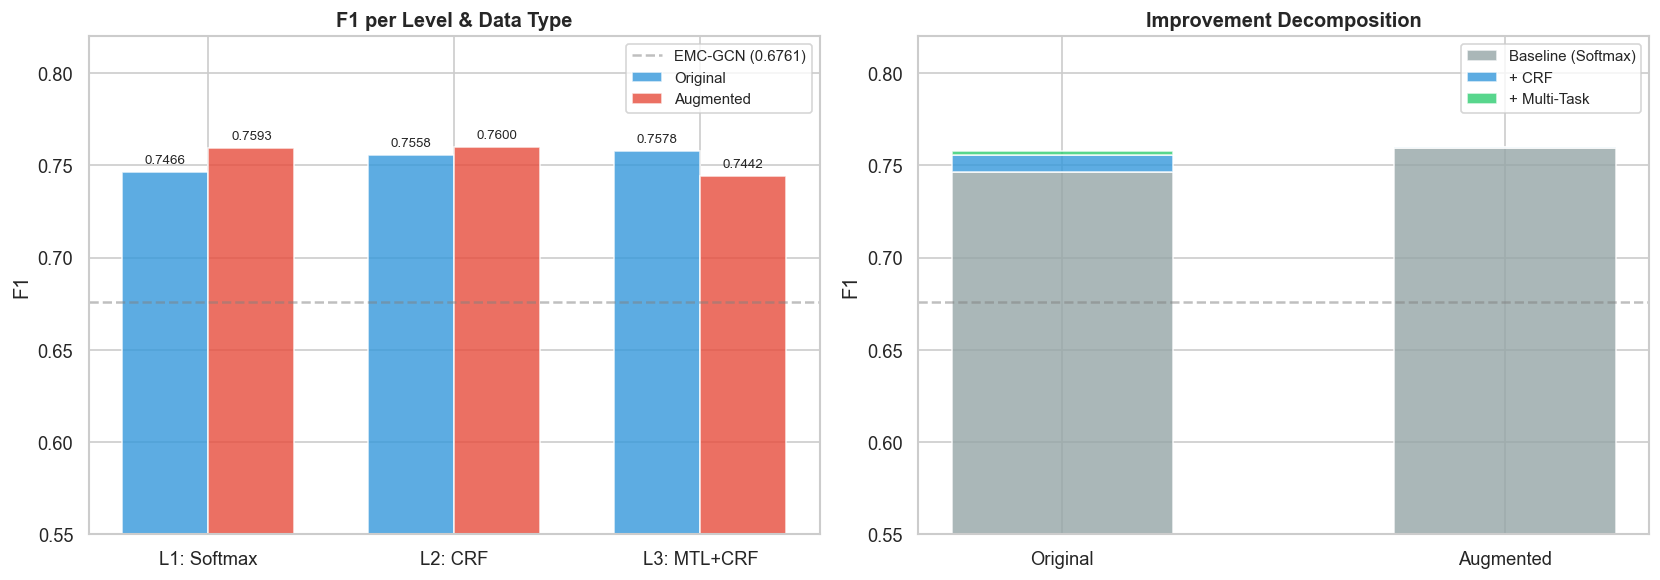

In [10]:
# 3-Level grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: F1 by level and data type
levels = ['L1: Softmax', 'L2: CRF', 'L3: MTL+CRF']
orig_f1s = [bl_orig, st_orig, mt_orig]
aug_f1s = [bl_aug, st_aug, mt_aug]

x = np.arange(len(levels))
width = 0.35
bars1 = axes[0].bar(x - width/2, orig_f1s, width, label='Original', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, aug_f1s, width, label='Augmented', color='#e74c3c', alpha=0.8)
axes[0].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5, label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')

for bars in [bars1, bars2]:
    for bar in bars:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                     f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

axes[0].set_title('F1 per Level & Data Type', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(levels)
axes[0].set_ylabel('F1')
axes[0].legend(fontsize=9)
axes[0].set_ylim(0.55, 0.82)

# Right: Improvement decomposition (stacked bar)
data_types = ['Original', 'Augmented']
crf_gains = [crf_gain_orig, crf_gain_aug]
mtl_gains = [max(mtl_gain_orig, 0), max(mtl_gain_aug, 0)]  # clip negative for stacking
baselines = [bl_orig, bl_aug]

x2 = np.arange(len(data_types))
axes[1].bar(x2, baselines, 0.5, label=f'Baseline (Softmax)', color='#95a5a6', alpha=0.8)
axes[1].bar(x2, crf_gains, 0.5, bottom=baselines, label=f'+ CRF', color='#3498db', alpha=0.8)
axes[1].bar(x2, mtl_gains, 0.5, bottom=[b + c for b, c in zip(baselines, crf_gains)],
            label=f'+ Multi-Task', color='#2ecc71', alpha=0.8)
axes[1].axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5)

axes[1].set_title('Improvement Decomposition', fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(data_types)
axes[1].set_ylabel('F1')
axes[1].legend(fontsize=9)
axes[1].set_ylim(0.55, 0.82)

plt.tight_layout()
plt.show()

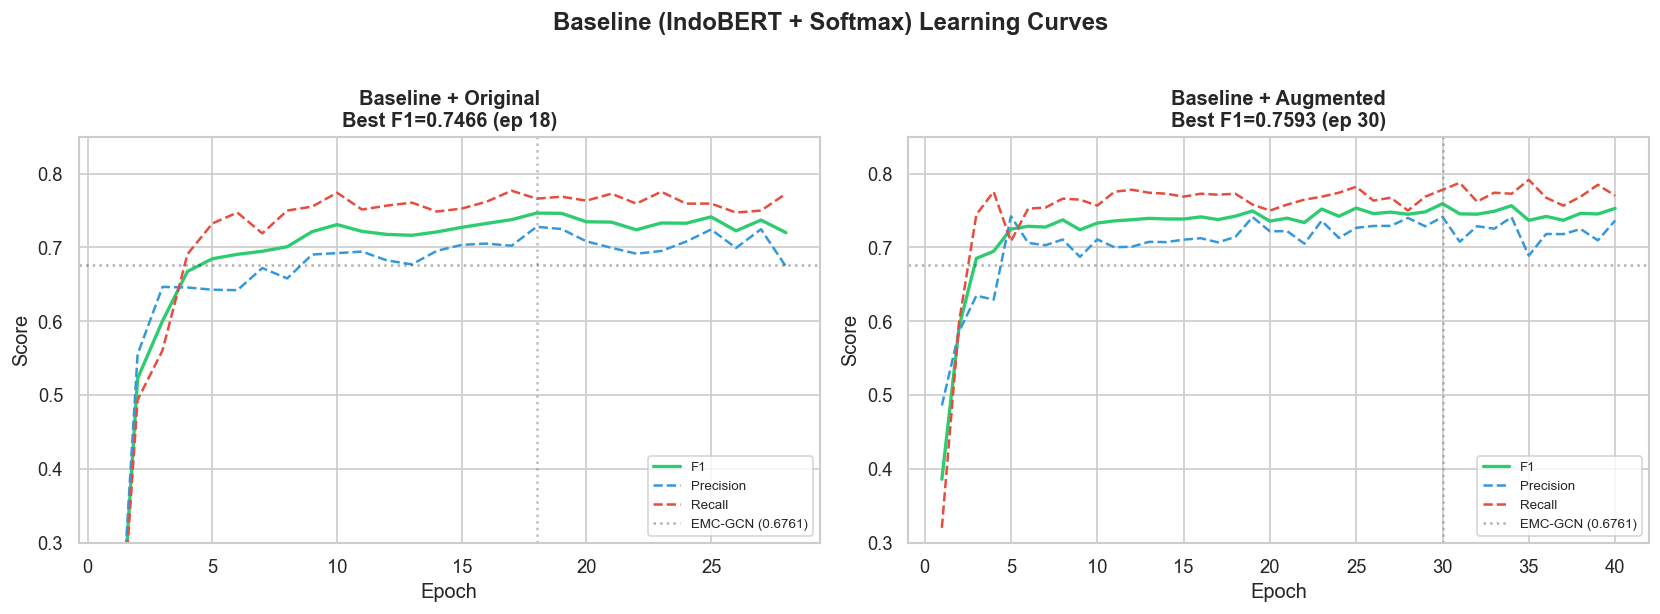

In [11]:
# Learning curves: baseline runs (2x1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (run_name, r) in enumerate(baseline_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)

    ax.plot(epochs, h['val_f1'], label='F1', color='#2ecc71', linewidth=2)
    ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=1.5, linestyle='--')
    ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=1.5, linestyle='--')

    best_ep = r['best_epoch']
    ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(PRIOR_RESEARCH_F1, color='black', linestyle=':', alpha=0.3, label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')

    ax.set_title(f'{run_name}\nBest F1={r["best_f1"]:.4f} (ep {best_ep})', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend(fontsize=8)
    ax.set_ylim(0.3, 0.85)

plt.suptitle('Baseline (IndoBERT + Softmax) Learning Curves', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

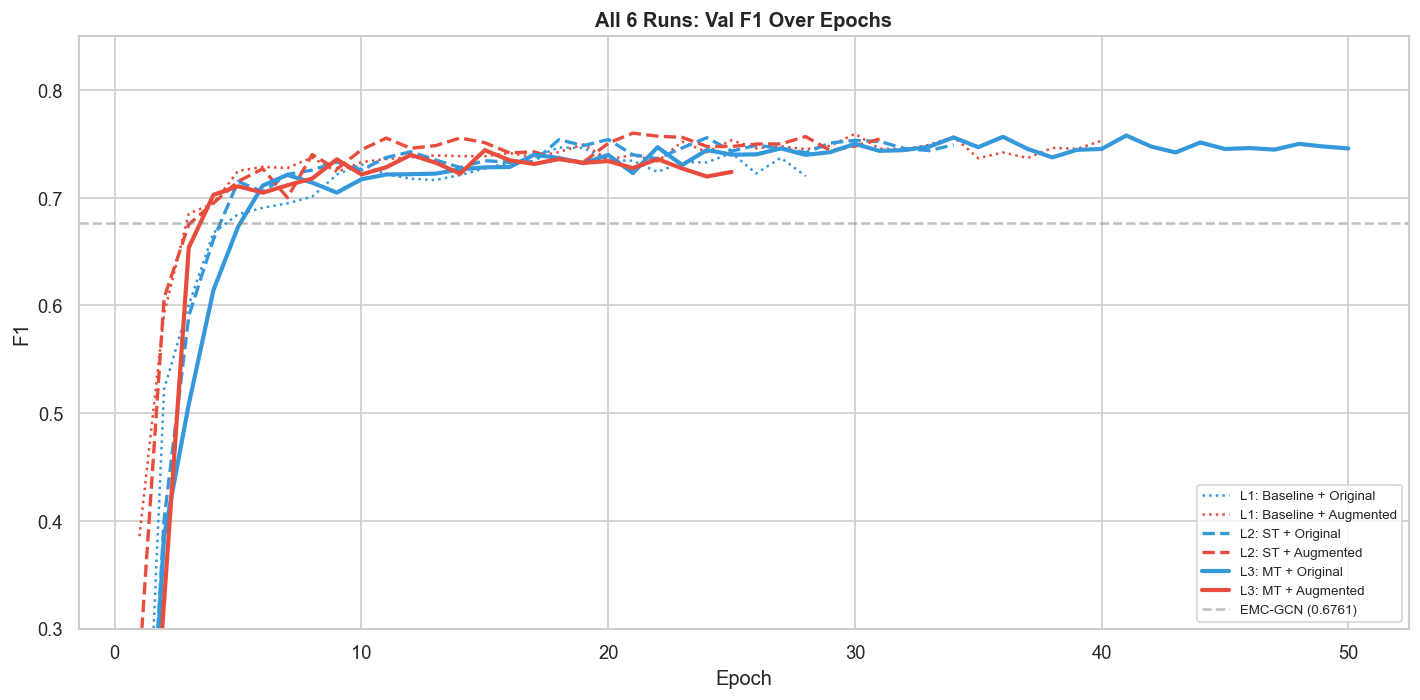

In [12]:
# All 6 F1 curves overlaid
fig, ax = plt.subplots(figsize=(12, 6))

level_styles = {
    1: {'linestyle': ':', 'linewidth': 1.5},    # Baseline: dotted
    2: {'linestyle': '--', 'linewidth': 2},      # CRF: dashed
    3: {'linestyle': '-', 'linewidth': 2.5},     # MTL: solid
}
data_colors = {'original': '#3498db', 'augmented': '#e74c3c'}

for name, r in all_results.items():
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    level = r['level']
    data_type = r.get('data_type', 'original' if 'Original' in name else 'augmented')
    style = level_styles[level]
    color = data_colors[data_type]
    ax.plot(epochs, h['val_f1'], label=f'L{level}: {name}', color=color, **style)

ax.axhline(PRIOR_RESEARCH_F1, color='gray', linestyle='--', alpha=0.5,
           label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')
ax.set_title('All 6 Runs: Val F1 Over Epochs', fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1')
ax.legend(fontsize=8, loc='lower right')
ax.set_ylim(0.3, 0.85)

plt.tight_layout()
plt.show()

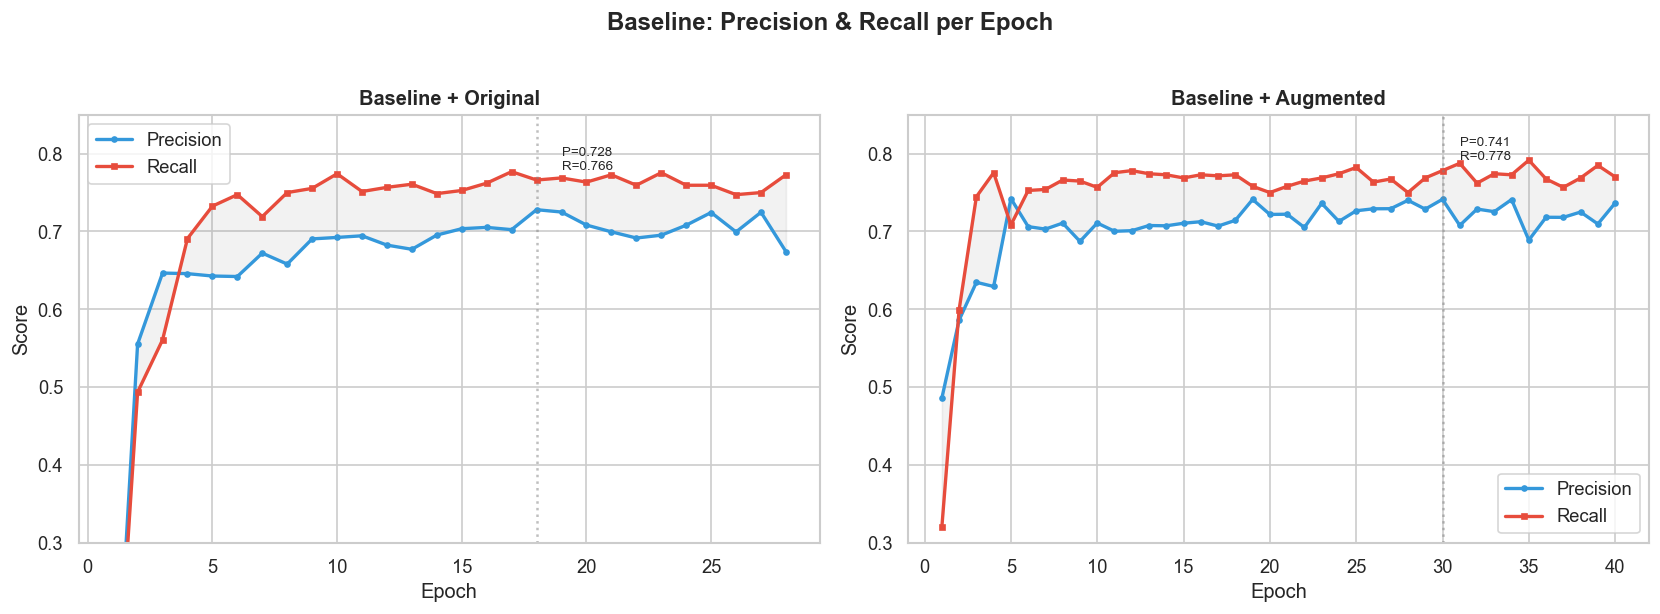

In [13]:
# Precision & Recall for baseline runs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (run_name, r) in enumerate(baseline_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)

    ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=2, marker='s', markersize=3)
    ax.fill_between(epochs, h['val_precision'], h['val_recall'], alpha=0.1, color='gray')

    best_ep = r['best_epoch']
    best_p = h['val_precision'][best_ep - 1]
    best_r = h['val_recall'][best_ep - 1]
    ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
    ax.annotate(f'P={best_p:.3f}\nR={best_r:.3f}', xy=(best_ep, max(best_p, best_r)),
                fontsize=8, ha='left', va='bottom',
                xytext=(best_ep + 1, max(best_p, best_r) + 0.01))

    ax.set_title(f'{run_name}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()
    ax.set_ylim(0.3, 0.85)

plt.suptitle('Baseline: Precision & Recall per Epoch', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 10. PER-CLASS COMPARISON

In [14]:
# Print baseline classification reports
for run_name, r in baseline_results.items():
    print(f'\n{"="*60}')
    print(f'{run_name} (F1={r["best_f1"]:.4f}, Epoch {r["best_epoch"]})')
    print(f'{"="*60}')
    print(r['report'])

# Cross-level per-class comparison (Original data)
print(f'\n{"="*70}')
print('CROSS-LEVEL PER-CLASS F1 (Original Data)')
print(f'{"="*70}')

from seqeval.metrics import classification_report as seq_report
import re

def extract_per_class_f1(report_str):
    """Extract per-class F1 from seqeval classification report string."""
    result = {}
    for line in report_str.strip().split('\n'):
        line = line.strip()
        for cls in ['NEG', 'NEU', 'POS']:
            if line.startswith(cls):
                parts = line.split()
                result[cls] = {'precision': float(parts[1]), 'recall': float(parts[2]), 'f1': float(parts[3])}
    return result

orig_runs = [
    ('L1: Baseline', all_results['Baseline + Original']),
    ('L2: CRF', all_results['ST + Original']),
    ('L3: MTL', all_results['MT + Original']),
]

print(f'\n{"":>15s} {"NEG":>20s} {"NEU":>20s} {"POS":>20s}')
print(f'{"":>15s} {"P     R     F1":>20s} {"P     R     F1":>20s} {"P     R     F1":>20s}')
print('-' * 78)

for label, r in orig_runs:
    cls = extract_per_class_f1(r['report'])
    neg = cls.get('NEG', {'precision': 0, 'recall': 0, 'f1': 0})
    neu = cls.get('NEU', {'precision': 0, 'recall': 0, 'f1': 0})
    pos = cls.get('POS', {'precision': 0, 'recall': 0, 'f1': 0})
    print(f'{label:>15s} '
          f'{neg["precision"]:.2f}  {neg["recall"]:.2f}  {neg["f1"]:.2f}      '
          f'{neu["precision"]:.2f}  {neu["recall"]:.2f}  {neu["f1"]:.2f}      '
          f'{pos["precision"]:.2f}  {pos["recall"]:.2f}  {pos["f1"]:.2f}')

# Same for augmented
print(f'\n{"="*70}')
print('CROSS-LEVEL PER-CLASS F1 (Augmented Data)')
print(f'{"="*70}')

aug_runs = [
    ('L1: Baseline', all_results['Baseline + Augmented']),
    ('L2: CRF', all_results['ST + Augmented']),
    ('L3: MTL', all_results['MT + Augmented']),
]

print(f'\n{"":>15s} {"NEG":>20s} {"NEU":>20s} {"POS":>20s}')
print(f'{"":>15s} {"P     R     F1":>20s} {"P     R     F1":>20s} {"P     R     F1":>20s}')
print('-' * 78)

for label, r in aug_runs:
    cls = extract_per_class_f1(r['report'])
    neg = cls.get('NEG', {'precision': 0, 'recall': 0, 'f1': 0})
    neu = cls.get('NEU', {'precision': 0, 'recall': 0, 'f1': 0})
    pos = cls.get('POS', {'precision': 0, 'recall': 0, 'f1': 0})
    print(f'{label:>15s} '
          f'{neg["precision"]:.2f}  {neg["recall"]:.2f}  {neg["f1"]:.2f}      '
          f'{neu["precision"]:.2f}  {neu["recall"]:.2f}  {neu["f1"]:.2f}      '
          f'{pos["precision"]:.2f}  {pos["recall"]:.2f}  {pos["f1"]:.2f}')


Baseline + Original (F1=0.7466, Epoch 18)
              precision    recall  f1-score   support

         NEG       0.58      0.58      0.58        83
         NEU       0.58      0.64      0.61       125
         POS       0.79      0.82      0.81       536

   micro avg       0.73      0.77      0.75       744
   macro avg       0.65      0.68      0.66       744
weighted avg       0.73      0.77      0.75       744


Baseline + Augmented (F1=0.7593, Epoch 30)
              precision    recall  f1-score   support

         NEG       0.60      0.63      0.62        83
         NEU       0.59      0.63      0.61       125
         POS       0.80      0.84      0.82       536

   micro avg       0.74      0.78      0.76       744
   macro avg       0.66      0.70      0.68       744
weighted avg       0.74      0.78      0.76       744


CROSS-LEVEL PER-CLASS F1 (Original Data)

                                 NEG                  NEU                  POS
                      P     R

### 11. KESIMPULAN

In [15]:
print('=' * 60)
print('KESIMPULAN 3-LEVEL COMPARISON')
print('=' * 60)

# Overall ranking
sorted_runs = sorted(all_results.items(), key=lambda x: x[1]['best_f1'], reverse=True)

print('\nRanking F1 (semua 6 konfigurasi):')
for i, (name, r) in enumerate(sorted_runs):
    print(f'  {i+1}. L{r["level"]} {name:<25s} F1={r["best_f1"]:.4f} (ep {r["best_epoch"]})')

# Decomposition summary
print(f'\nDekomposisi Kontribusi (Original data):')
print(f'  Baseline (Softmax)    : {bl_orig:.4f}')
print(f'  + CRF                 : {crf_gain_orig:+.4f} -> {st_orig:.4f}')
print(f'  + Multi-Task Learning : {mtl_gain_orig:+.4f} -> {mt_orig:.4f}')

print(f'\nDekomposisi Kontribusi (Augmented data):')
print(f'  Baseline (Softmax)    : {bl_aug:.4f}')
print(f'  + CRF                 : {crf_gain_aug:+.4f} -> {st_aug:.4f}')
print(f'  + Multi-Task Learning : {mtl_gain_aug:+.4f} -> {mt_aug:.4f}')

# vs EMC-GCN
print(f'\nSemua konfigurasi vs EMC-GCN ({PRIOR_RESEARCH_F1}):')
for name, r in sorted_runs:
    diff = r['best_f1'] - PRIOR_RESEARCH_F1
    print(f'  L{r["level"]} {name:<25s}: +{diff:.4f}')

# Key findings
print(f'\nKey Findings:')
print(f'  1. CRF kontribusi terbesar: +{crf_gain_orig:.4f} (orig) / +{crf_gain_aug:.4f} (aug)')
print(f'  2. MTL kontribusi tambahan: {mtl_gain_orig:+.4f} (orig) / {mtl_gain_aug:+.4f} (aug)')
print(f'  3. Total MTL vs Baseline: +{total_gain_orig:.4f} (orig) / +{total_gain_aug:.4f} (aug)')
print(f'  4. Semua level mengalahkan EMC-GCN ({PRIOR_RESEARCH_F1})')

KESIMPULAN 3-LEVEL COMPARISON

Ranking F1 (semua 6 konfigurasi):
  1. L2 ST + Augmented            F1=0.7600 (ep 21)
  2. L1 Baseline + Augmented      F1=0.7593 (ep 30)
  3. L3 MT + Original             F1=0.7578 (ep 41)
  4. L2 ST + Original             F1=0.7558 (ep 24)
  5. L1 Baseline + Original       F1=0.7466 (ep 18)
  6. L3 MT + Augmented            F1=0.7442 (ep 15)

Dekomposisi Kontribusi (Original data):
  Baseline (Softmax)    : 0.7466
  + CRF                 : +0.0092 -> 0.7558
  + Multi-Task Learning : +0.0021 -> 0.7578

Dekomposisi Kontribusi (Augmented data):
  Baseline (Softmax)    : 0.7593
  + CRF                 : +0.0007 -> 0.7600
  + Multi-Task Learning : -0.0158 -> 0.7442

Semua konfigurasi vs EMC-GCN (0.6761):
  L2 ST + Augmented           : +0.0839
  L1 Baseline + Augmented     : +0.0832
  L3 MT + Original            : +0.0817
  L2 ST + Original            : +0.0797
  L1 Baseline + Original      : +0.0705
  L3 MT + Augmented           : +0.0681

Key Findings:
  1

### 12. SIMPAN HASIL

In [ ]:
checkpoint = {
    'all_results': all_results,
    'baseline_results': baseline_results,
    'decomposition': {
        'original': {
            'baseline': bl_orig, 'crf_gain': crf_gain_orig,
            'mtl_gain': mtl_gain_orig, 'total_gain': total_gain_orig,
        },
        'augmented': {
            'baseline': bl_aug, 'crf_gain': crf_gain_aug,
            'mtl_gain': mtl_gain_aug, 'total_gain': total_gain_aug,
        },
    },
    'config': {
        'model_name': MODEL_NAME,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
        'seed': SEED,
    },
    'prior_research_f1': PRIOR_RESEARCH_F1,
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_three_level.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')

best_name = max(all_results, key=lambda k: all_results[k]['best_f1'])
print(f'\nBest overall: {best_name} (F1={all_results[best_name]["best_f1"]:.4f})')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_three_level.pt
File size: 0.5 MB

Best overall: ST + Augmented (F1=0.7600)


: 